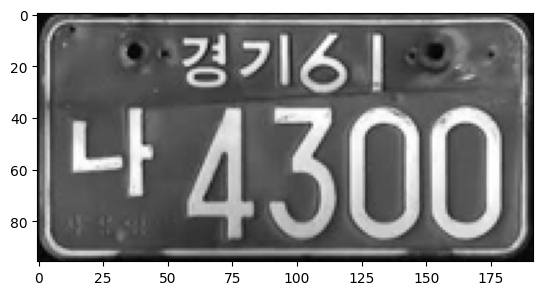

In [83]:
import os, random, glob, sys, time

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

img_path = glob.glob('data/*')
# shuffle the list
random.shuffle(img_path)
im = Image.open(img_path[0]).convert('L').resize((192, 96))
im = np.array(im)


# show via matplotlib
plt.imshow(im, cmap='gray')
plt.show()

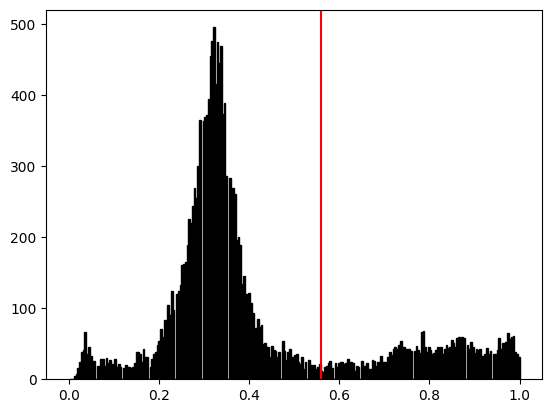

496 68


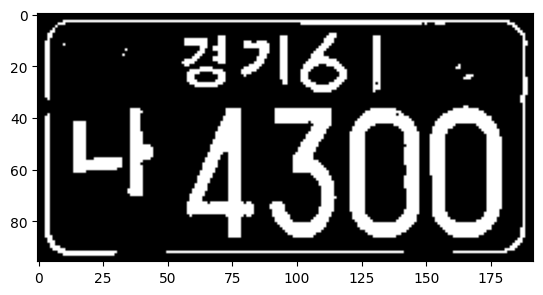

In [84]:
# using kmeans to cluster the image to 2 clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
# normalize the image via min-max normalization
im = (im - im.min()) / (im.max() - im.min())


# using otus method to get the threshold
from skimage.filters import threshold_otsu
thresh = threshold_otsu(im)
binary = im > thresh
# plt.imshow(binary, cmap='gray')
# plt.show()

# show threshold as histogram
plt.hist(im.ravel(), bins=256, range=(0, 1), fc='k', ec='k')
plt.axvline(thresh, color='r')
plt.show()

# get histogram value
hist, bins = np.histogram(im.ravel(), 256, [0, 1])

l_thresh = int(256 * thresh)
# max left and max right
l_max = np.max(hist[:l_thresh])
r_max = np.max(hist[l_thresh:])
print(l_max, r_max)

if l_max < r_max:
    binary = im < thresh

plt.imshow(binary, cmap='gray')
plt.show()

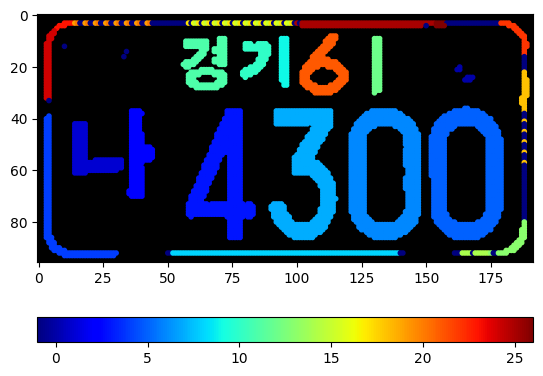

In [85]:
# image to 2d points
# normalize the points to 0-1

# binary = (binary - binary.min()) / (binary.max() - binary.min())
points = np.argwhere(binary > 0.5)

# using dbscan to cluster the points to clusters
from sklearn.cluster import *
# dbscan = DBSCAN(eps=2, min_samples=10)
dbscan = HDBSCAN(min_cluster_size=8)
dbscan.fit(points)
labels = dbscan.labels_
# get the number of clusters
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# transform the points to the original image
points = points[:, ::-1]
plt.imshow(np.ones(im.shape) * 255, cmap='gray')
plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='jet', s=9)
# show color bar horizontally
plt.colorbar(orientation='horizontal')

plt.show()

/var/folders/4q/b74r5j053dz_54w1vk03m_mw0000gn/T/ipykernel_1026/703929996.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(cluster[:, 0], cluster[:, 1], np.ones(len(cluster)) * i, c=colors[i], s=5)


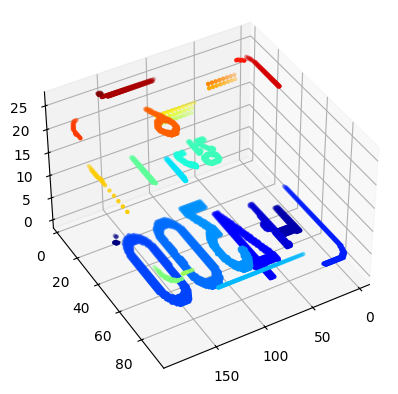

In [86]:
# 3d plot via matplotlib
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# get the color of each cluster
colors = plt.cm.jet(np.linspace(0, 1, n_clusters))
for i in range(n_clusters):
    cluster = points[labels == i]
    ax.scatter(cluster[:, 0], cluster[:, 1], np.ones(len(cluster)) * i, c=colors[i], s=5)

# view to 
ax.view_init(40, 60)
plt.show()

number of clusters: 27


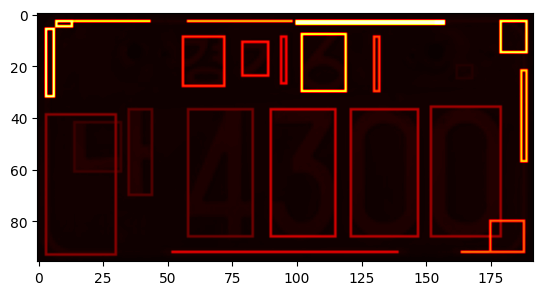

In [87]:
# show the number of clusters
print('number of clusters:', n_clusters)

# sort the clusters by the area of the cluster
from collections import Counter
counter = Counter(labels)

# draw the bounding box of each cluster
for i in range(n_clusters):
    cluster = points[labels == i]
    x1, y1 = np.min(cluster, axis=0)
    x2, y2 = np.max(cluster, axis=0)
    cv2.rectangle(im, (x1, y1), (x2, y2), i + 1, 1)

plt.imshow(im, cmap='hot')
plt.show()

/var/folders/4q/b74r5j053dz_54w1vk03m_mw0000gn/T/ipykernel_1026/1107304996.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  exp_factory = 1 / 2.0 / sigmay / sigmay


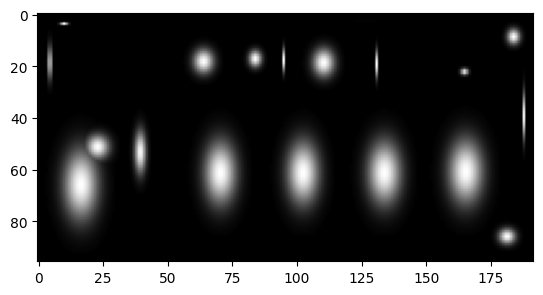

In [88]:
# draw 2d guassian via given bbox
def draw_ttfnet_gaussian(heatmap, center, sigmax, sigmay, mask=None):
    center_x, center_y = center[0], center[1]
    th = 4.6052
    delta = np.sqrt(th * 2)

    height = heatmap.shape[0]
    width = heatmap.shape[1]

    x0 = int(max(0, center_x - delta * sigmax + 0.5))
    y0 = int(max(0, center_y - delta * sigmay + 0.5))
    x1 = int(min(width, center_x + delta * sigmax + 0.5))
    y1 = int(min(height, center_y + delta * sigmay + 0.5))

    ## fast way
    arr_heat = heatmap[y0:y1, x0:x1]
    exp_factorx = 1 / 2.0 / sigmax / sigmax
    exp_factory = 1 / 2.0 / sigmay / sigmay
    x_vec = (np.arange(x0, x1) - center_x) ** 2
    y_vec = (np.arange(y0, y1) - center_y) ** 2
    arr_sumx = exp_factorx * x_vec
    arr_sumy = exp_factory * y_vec
    xv, yv = np.meshgrid(arr_sumx, arr_sumy)
    arr_sum = xv + yv
    arr_exp = np.exp(-arr_sum)
    arr_exp[arr_sum > th] = 0

    heatmap[y0:y1, x0:x1] = np.maximum(arr_heat, arr_exp)
    if mask is not None:
        mask[y0:y1, x0:x1] = 1
        return heatmap, mask
    return heatmap


im = np.zeros(im.shape)
# draw the gaussian of each cluster
for i in range(n_clusters):
    cluster = points[labels == i]
    x1, y1 = np.min(cluster, axis=0)
    x2, y2 = np.max(cluster, axis=0)
    center = [(x1 + x2) / 2, (y1 + y2) / 2]
    sigmax = (x2 - x1) / 6
    sigmay = (y2 - y1) / 6
    im = draw_ttfnet_gaussian(im, center, sigmax, sigmay)


plt.imshow(im, cmap='gray')
plt.show()

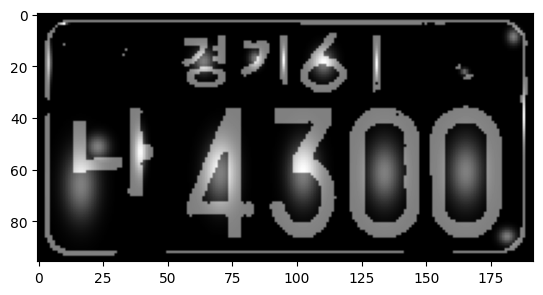

In [89]:
# im * 0.5 alpha + binary * 0.5 beta
# show the heatmap
plt.imshow(im * 0.5 + binary * 0.5, cmap='gray')
plt.show()
